<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/china/blob/main/covid19_95_accuracy_death_prediction_rf_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing modules and data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [5]:

path = "/content/drive/MyDrive/중국/COVID19/Covid Data.csv"
df = pd.read_csv(path)

# 2. Exploratory Data Analysis and Feature Engineering

The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- sex: 1 for female and 2 for male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease: whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- tobacco: whether the patient is a tobacco user.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

Besides 97 and 99, it was also found that the value 98 was present in some of the categorical variables, which is assumed to also mean a missing value.

In [6]:
df.isin([97, 98, 99]).any()

,0
USMER,False
MEDICAL_UNIT,False
SEX,False
PATIENT_TYPE,False
DATE_DIED,False
INTUBED,True
PNEUMONIA,True
AGE,True
PREGNANT,True
DIABETES,True


This convention for missing values of course creates some problems wrt. the AGE variable, where these numbers are valid values. Looking closer at the number of occurrences within the AGE variable above the age of 90, the count of 97, 98 and 99 seem as expected compared to the adjacent values, so it's assumed that they do not denote a missing value for this continuous variable.

In [7]:
df.loc[df["AGE"]>90, "AGE"].value_counts()

,count
AGE,
91,595
92,449
93,376
94,281
95,271
96,195
97,135
98,124
99,86


For the remaining (categorical) variables, these three numbers are replaced with NaN, so they can be handled properly later.

In [8]:
df[df.columns.drop("AGE")] = df[df.columns.drop("AGE")].replace([97, 98, 99], np.nan)

The target variable, whether the patient died or not, can be deducted from "date died". We follow the orthodox notation of using 0 for False and 1 for True.

In [9]:
df["DIED"] = df["DATE_DIED"].apply(lambda x: 0 if x == "9999-99-99" else 1)

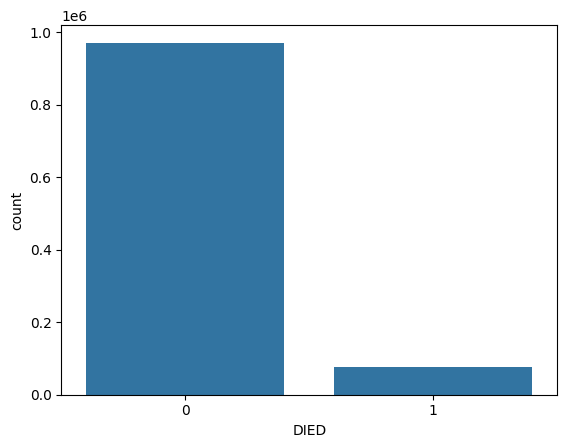

In [10]:
sns.countplot(data=df, x="DIED")
plt.show()

As can be seen, the target variable is quite imbalanced.

The date of death is dropped as it is not the target variable and using it as a predictor would cause data leakage.

In [11]:
df = df.drop("DATE_DIED", axis=1)

## 2.1 Summary of Data Characteristics
Getting an overview of the data at hand

In [12]:
df.head(10)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DIED
0,2,1,1,1,NaN,1.0,65,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,NaN,1
1,2,1,2,1,NaN,1.0,72,NaN,2.0,2.0,...,2.0,1.0,2.0,2.0,1.0,1.0,2.0,5,NaN,1
2,2,1,2,2,1.0,2.0,55,NaN,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1
3,2,1,1,1,NaN,2.0,53,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN,1
4,2,1,2,1,NaN,2.0,68,NaN,1.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,NaN,1
5,2,1,1,2,2.0,1.0,40,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,0
6,2,1,1,1,NaN,2.0,64,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,NaN,0
7,2,1,1,1,NaN,1.0,64,2.0,1.0,2.0,...,1.0,1.0,2.0,2.0,2.0,1.0,2.0,3,NaN,0
8,2,1,1,2,2.0,2.0,37,2.0,1.0,2.0,...,2.0,1.0,2.0,2.0,1.0,2.0,2.0,3,2.0,0
9,2,1,1,2,2.0,2.0,25,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   USMER                 1048575 non-null  int64  
 1   MEDICAL_UNIT          1048575 non-null  int64  
 2   SEX                   1048575 non-null  int64  
 3   PATIENT_TYPE          1048575 non-null  int64  
 4   INTUBED               192706 non-null   float64
 5   PNEUMONIA             1032572 non-null  float64
 6   AGE                   1048575 non-null  int64  
 7   PREGNANT              521310 non-null   float64
 8   DIABETES              1045237 non-null  float64
 9   COPD                  1045572 non-null  float64
 10  ASTHMA                1045596 non-null  float64
 11  INMSUPR               1045171 non-null  float64
 12  HIPERTENSION          1045471 non-null  float64
 13  OTHER_DISEASE         1043530 non-null  float64
 14  CARDIOVASCULAR        1045499 non-

In [14]:
df.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DIED
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,192706.000000,1.032572e+06,1.048575e+06,521310.000000,1.045237e+06,1.045572e+06,...,1.045171e+06,1.045471e+06,1.043530e+06,1.045499e+06,1.045543e+06,1.045569e+06,1.045355e+06,1.048575e+06,192543.000000,1.048575e+06
mean,1.632194e+00,8.980565e+00,1.499259e+00,1.190765e+00,1.825351,1.864379e+00,4.179410e+01,1.984403,1.880420e+00,1.985594e+00,...,1.986442e+00,1.844349e+00,1.973130e+00,1.980135e+00,1.847145e+00,1.981920e+00,1.919285e+00,5.305653e+00,1.912446,7.337768e-02
std,4.822084e-01,3.723278e+00,4.999997e-01,3.929041e-01,0.379668,3.423854e-01,1.690739e+01,0.123911,3.244694e-01,1.191554e-01,...,1.156451e-01,3.625247e-01,1.617045e-01,1.395369e-01,3.598474e-01,1.332413e-01,2.723973e-01,1.881165e+00,0.282647,2.607556e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.000000e+00
25%,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,2.000000,2.000000e+00,3.000000e+01,2.000000,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000,0.000000e+00
50%,2.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,2.000000,2.000000e+00,4.000000e+01,2.000000,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,2.000000,0.000000e+00
75%,2.000000e+00,1.200000e+01,2.000000e+00,1.000000e+00,2.000000,2.000000e+00,5.300000e+01,2.000000,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,2.000000,0.000000e+00
max,2.000000e+00,1.300000e+01,2.000000e+00,2.000000e+00,2.000000,2.000000e+00,1.210000e+02,2.000000,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,2.000000,1.000000e+00


Assessing that the number of non-NA unique values for each categorical variable matches the expectations. Specifically for the binary categories, we expect to see only two unique values.

In [15]:
df.nunique()

,0
USMER,2
MEDICAL_UNIT,13
SEX,2
PATIENT_TYPE,2
INTUBED,2
PNEUMONIA,2
AGE,121
PREGNANT,2
DIABETES,2
COPD,2


As can be seen from the summary above, the data set consists of 20 features, with AGE being the only non-categorical features, and MEDICAL_UNIT and CLASIFFICATION_FINAL being the only non-binary categorical features.

Overview of the correlation between the numerical variables. Gives a good overview of what features provide information about the target variable, DIED.

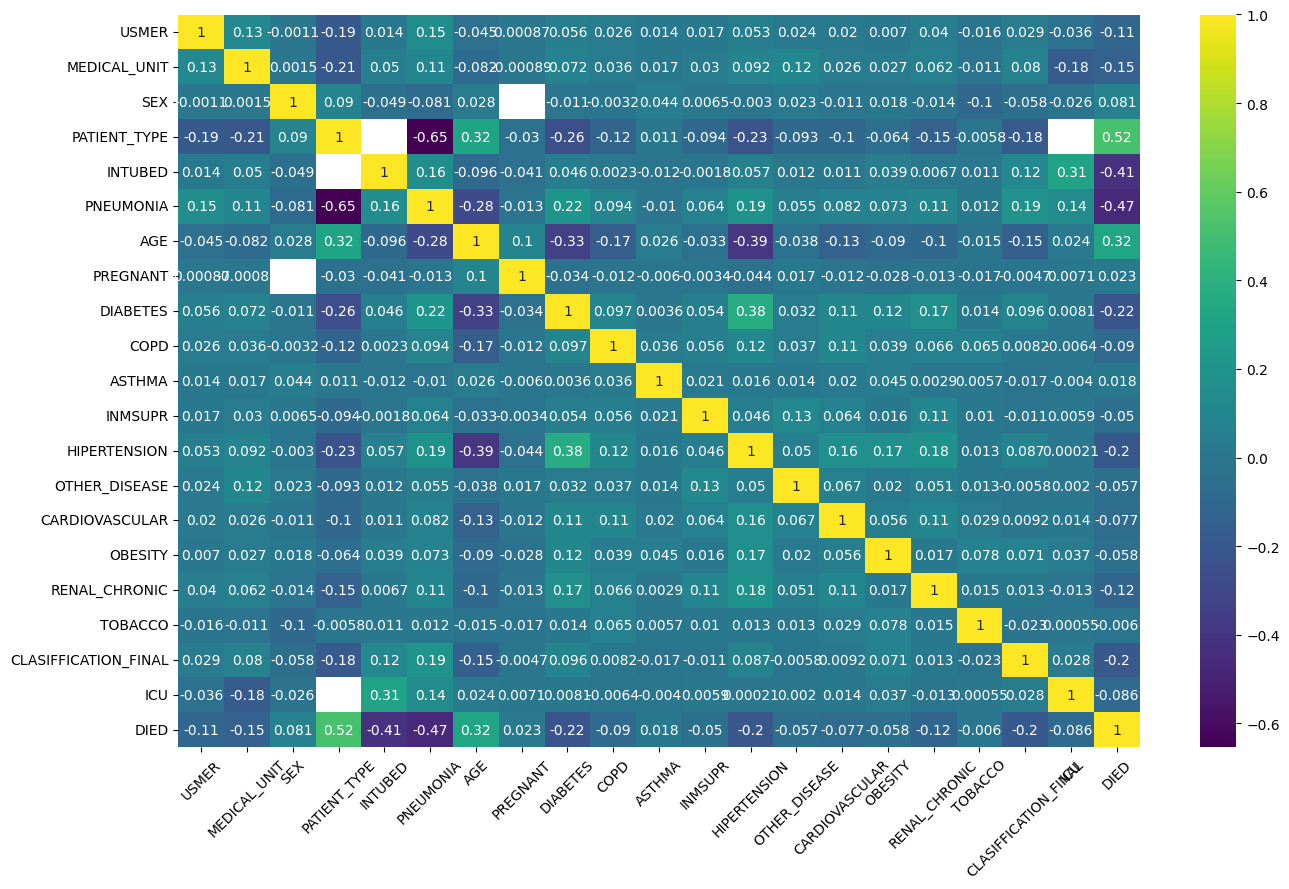

In [16]:
plt.figure(figsize=(14, 9))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="viridis")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Recall that for the categorical variables, 1=True and 2=False.\
From the correlations, we see the following relationships:
- Patients that are sent home (PATIENT_TYPE = 1) have a significantly lower risk of dying (or vice versa!).
- Patients that are INTUBED and patients that have PNEUMONIA have a significantly higher risk of dying.
- Patients that are older have a higher risk of dying.
- Patients with DIABETES, COPD, HIPERTENSION and RENAL_CHRONIC have a moderately higher risk of dying.

Important note: These are correlations which do not mean causality. While it seems reasonable that pneumonia increases a patient's risk of dying (and not the other way around), it is likely not the intubation or hospitalization that increases the risk of the patient dying; rather, the doctor has likely (and correctly) estimated, that the patient is at high risk and has thus applied these measures where needed.

## 2.2 Data Imputation
Handling missing values

### INTUBED/ICU:
These two variables have 192706 and 192543 non-NA values, respectively (out of a total of 1048575), but they are closely related as can be seen below.

In [17]:
(df["INTUBED"].notna() & df["ICU"].isna()).sum() + (df["INTUBED"].isna() & df["ICU"].notna()).sum()

167

Only in 167 cases is one of the two features known without the other being known, so they appear to be tightly connected.

Considering the ability of the two variables to predict the likelihood that the patient dies:

In [18]:
df.groupby(by=["INTUBED", "ICU"], dropna=False)["DIED"].agg(["mean", "count"])

mean   count
INTUBED ICU                  
1.0     1.0  0.663873    9306
        2.0  0.831207   24296
        NaN  0.148148      54
2.0     1.0  0.267082    7552
        2.0  0.261449  151387
        NaN  0.036036     111
NaN     2.0  0.000000       2
        NaN  0.010469  855867

Interesting observation, a missing observation for both ICU and INTUBED seems to be a very good predictor of a significantly higher survival rate than e.g. both INTUBED and ICU being false.\
Looking at the correlation matrix for an explanation, there seems to be a special relationship between PATIENT_TYPE and INTUBED/ICU.

In [19]:
df[["PATIENT_TYPE", "INTUBED", "ICU"]].value_counts(dropna=False)

PATIENT_TYPE  INTUBED  ICU
1             NaN      NaN    848544
2             2.0      2.0    151387
              1.0      2.0     24296
                       1.0      9306
              2.0      1.0      7552
              NaN      NaN      7323
              2.0      NaN       111
              1.0      NaN        54
              NaN      2.0         2
Name: count, dtype: int64

It seems to be a prerequisite that the patient is hospitalized, i.e. of PATIENT_TYPE 2, before the features INTUBED and ICU are assigned a value. However, even without the biggest domain knowledge, we can quite safely say, that patients who are sent home, i.e. PATIENT_TYPE 1, are indeed not INTUBED (usually requires hospitalization) or amitted to the ICU (which is a part of the hospital and would imply hospitalization). Thus, we can assign the value 2 (False) for these two features for patients of type 1.

In [20]:
df.loc[df["PATIENT_TYPE"]==1, ["INTUBED", "ICU"]] = 2

We can also see that when INTUBED=2 (False), ICU is most likely also 2, so we use that value for imputation.

In [21]:
df.loc[(df["INTUBED"]==2) & (df["ICU"].isna()), "ICU"] = 2

The remaining combinations are not quite one-sided enough to be grouped and imputated.

### PNEUMONIA:
This feature has a significant amount of missing values.

As was seen from the correlation analysis, this factor seems to corrrelate strongly with PATIENT_TYPE.

In [22]:
df.groupby(["PATIENT_TYPE"])["PNEUMONIA"].value_counts(normalize=True)

PATIENT_TYPE  PNEUMONIA
1             2.0          0.972311
              1.0          0.027689
2             1.0          0.599542
              2.0          0.400458
Name: proportion, dtype: float64

It seems that having PNEUMONIA is very likely to get one hospitalized, i.e. it is very unusual for patients to be sent home if they suffer from PNEUMONIA, so we can impute the missing values for those patients that get sent home by,

In [23]:
df.loc[df["PATIENT_TYPE"]==1, "PNEUMONIA"] = df.loc[df["PATIENT_TYPE"]==1, "PNEUMONIA"].fillna(2)

Patients of type 2 are too ambivalent and the missing values are not filled.

### PREGNANT:
This feature has a high proportion of missing values.

In [24]:
df.groupby("SEX")["PREGNANT"].value_counts(dropna=False)

SEX  PREGNANT
1    2.0         513179
     1.0           8131
     NaN           3754
2    NaN         523511
Name: count, dtype: int64

As can be seen, all the pregnant statuses for males are missing likely due to it being deemed unnecessary to check. We can fill them with the value 2 for False.

In [25]:
df.loc[df["SEX"]==2, "PREGNANT"] = 2

Also, given that pregnancy is very unlikely above the age of 42, those missing values are filled to False.

In [26]:
df.loc[(df["AGE"]>=42) & (df["SEX"] == 1), "PREGNANT"].value_counts()

,count
PREGNANT,
2.0,241376
1.0,184


In [27]:
df.loc[(df["PREGNANT"].isna()) & (df["AGE"]>=42), "PREGNANT"] = 2

### DIABETES:

Diabetes is mostly something people develop later in life and is not very prevalent among those under 30 years of age.

In [28]:
df.loc[df["AGE"]<30, "DIABETES"].value_counts(normalize=True)

,proportion
DIABETES,
2.0,0.988349
1.0,0.011651


In [29]:
df.loc[df["AGE"]<30, "DIABETES"] = df.loc[df["AGE"]<30, "DIABETES"].fillna(2)

Also, among those from 30 - 40 years, an absence of hypertension is related to an absence of diabetes.

In [30]:
df.loc[df["AGE"].between(30, 40)].groupby("HIPERTENSION")["DIABETES"].value_counts(normalize=True)

HIPERTENSION  DIABETES
1.0           2.0         0.802623
              1.0         0.197377
2.0           2.0         0.970082
              1.0         0.029918
Name: proportion, dtype: float64

In [31]:
df.loc[(df["AGE"].between(30, 40)) & (df["HIPERTENSION"]==2), "DIABETES"].fillna(2, inplace=True)

### HIPERTENSION

Below the age of 30, hypertension is quite unusual.

In [32]:
df.loc[df["AGE"]<30, "HIPERTENSION"].value_counts(normalize=True)

,proportion
HIPERTENSION,
2.0,0.981784
1.0,0.018216


In [33]:
df.loc[df["AGE"]<30, "HIPERTENSION"] = df.loc[df["AGE"]<30, "HIPERTENSION"].fillna(2)

### Remaining missing values

In [34]:
df.isna().any(axis=1).mean()

0.0159359130248194

After the imputation of missing values done above, around 1.6% of the observations have a missing value in at least one of the columns. This proportion of data availability is considered satisfactory, and these remaining rows are dropped.

In [35]:
df = df.dropna()

## 2.3 Categorical Variables
Transforming into dummy variables

In [36]:
df = pd.get_dummies(df, columns=df.columns.drop(["AGE", "DIED"]), drop_first=True)

# 3. Splitting Data
Creating training and test data sets

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("DIED", axis=1), df["DIED"], test_size=0.3, random_state=42)

# 4. Training Models
Selected models for the prediction task.

Selecting the correct model and finding the most optimal hyperparameters are often a big part of the machine learning calibration process. However, the data in this project is very 'simple' in the sense that all features but one are categorical, and most of these categorical features are binary. Thus, a simple linear model might perform as well (or better) than the more complex model, that usually excel when the relationship between the features and the target variable is more complex.\
Different specifications were tested for the two models with very moderate variation wrt. performance.

## 4.1 Random Forest Model
Ensemble model using bagging

In [38]:
model_rf = RandomForestClassifier(n_estimators=400)

In [39]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400)

In [40]:
predictions_rf = model_rf.predict(X_test)

## 4.2 Neural Network
Fitted on scaled data using early stopping

In [41]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
model_nn = Sequential()

In [43]:
model_nn.add(Dense(38, activation="relu"))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(19, activation="relu"))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(1, activation="sigmoid"))
model_nn.compile(optimizer="adam", loss="binary_crossentropy")

In [44]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

In [45]:
model_nn.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=150, batch_size=128, callbacks=[early_stop])

Epoch 1/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1538 - val_loss: 0.1088
Epoch 2/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.1125 - val_loss: 0.1084
Epoch 3/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.1125 - val_loss: 0.1077
Epoch 4/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.1108 - val_loss: 0.1073
Epoch 5/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1113 - val_loss: 0.1075
Epoch 6/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.1095 - val_loss: 0.1072
Epoch 7/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1109 - val_loss: 0.1076
Epoch 8/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1097 - val_loss: 0.1073
Epoch 9/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.1096 - val_loss: 0.1072
Epoch 10/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.1100 - val_loss: 0.1069
Epoch 11/150
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.1107 - val_loss: 0.1074
Epoch 12

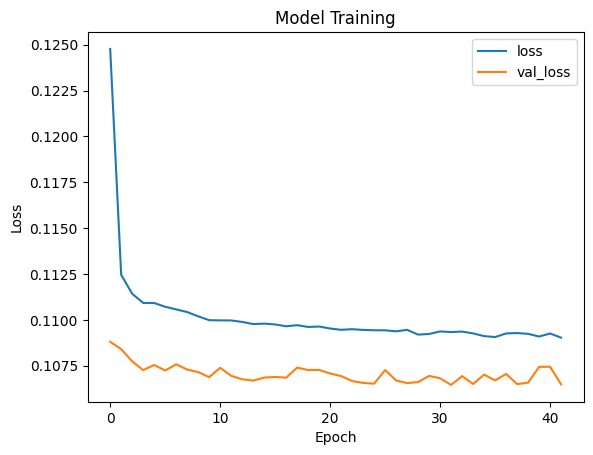

In [46]:
losses = pd.DataFrame(model_nn.history.history)
losses.plot()
plt.title("Model Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [47]:
pred_nn = model_nn.predict(X_test)
predictions_nn = np.where(pred_nn > 0.5, 1, 0)

9674/9674 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


# 5. Model Performance
Comparing metrics for the two selected models

## 5.1 Random Forest

In [48]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    287755
           1       0.64      0.53      0.58     21805

    accuracy                           0.95    309560
   macro avg       0.80      0.75      0.77    309560
weighted avg       0.94      0.95      0.94    309560



In [49]:
print(confusion_matrix(y_test, predictions_rf))

[[281350   6405]
 [ 10326  11479]]


## 5.2 Neural Network

In [50]:
print(confusion_matrix(y_test, predictions_nn))

[[284038   3717]
 [ 10773  11032]]


In [51]:
print(classification_report(y_test, predictions_nn))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    287755
           1       0.75      0.51      0.60     21805

    accuracy                           0.95    309560
   macro avg       0.86      0.75      0.79    309560
weighted avg       0.95      0.95      0.95    309560



As can be seen, the performances of the two models are very similar.